데이터 다운로드 시작 (한 종목씩 진행)...
[LVMUY] 다운로드 중... 성공
[HESAY] 다운로드 중... 성공
[CFRUY] 다운로드 중... 성공
[IDEXY] 다운로드 중... 성공
[HNNMY] 다운로드 중... 성공
[GPS] 다운로드 중... 


1 Failed download:
['GPS']: YFTzMissingError('possibly delisted; no timezone found')


실패 (데이터 없음)
[^VIX] 다운로드 중... 성공

[데이터 다운로드 완료]
성공한 티커: ['LVMUY', 'HESAY', 'CFRUY', 'IDEXY', 'HNNMY', '^VIX']

[최종 분석 데이터 (상위 5행)]
                 Gap  Gap_Lag1    VIX
Date                                 
2015-03-01  0.015318  0.017724  15.29
2015-04-01  0.045642  0.015318  14.55
2015-05-01  0.019042  0.045642  13.84
2015-06-01  0.015141  0.019042  18.23
2015-07-01  0.009831  0.015141  12.12


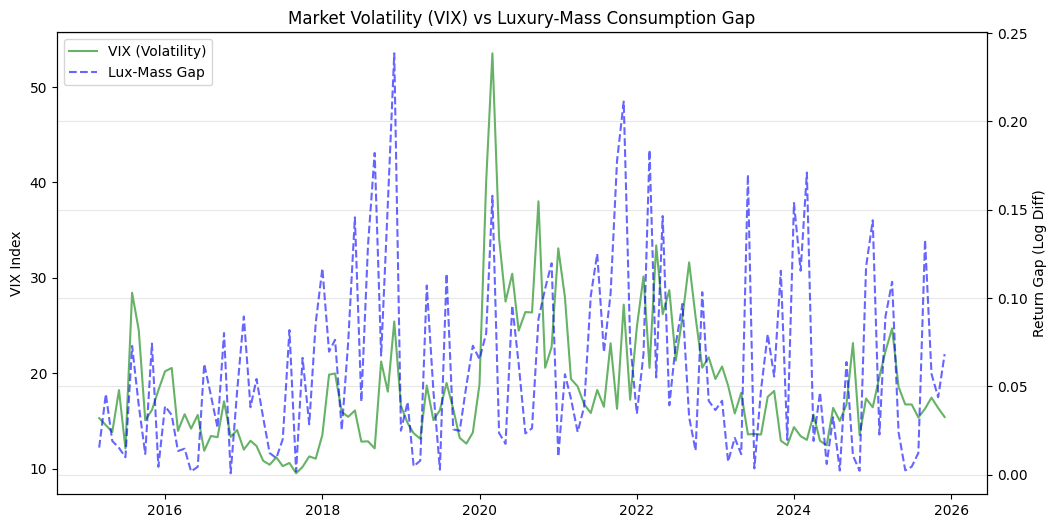

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 티커 설정
# ---------------------------------------------------------
luxury_tickers = ['LVMUY', 'HESAY', 'CFRUY'] 
mass_tickers = ['IDEXY', 'HNNMY', 'GPS'] 
market_tickers = ['^VIX']

all_tickers = luxury_tickers + mass_tickers + market_tickers

# ---------------------------------------------------------
# 2. 데이터 다운로드 (개별 다운로드 방식)
# ---------------------------------------------------------
print("데이터 다운로드 시작 (한 종목씩 진행)...")

data_store = {} # 데이터를 임시 저장할 딕셔너리

for ticker in all_tickers:
    try:
        print(f"[{ticker}] 다운로드 중...", end=" ")
        # auto_adjust=False로 설정하여 경고 메시지 방지 및 명시적 데이터 요청
        temp_df = yf.download(ticker, start='2015-01-01', interval='1mo', progress=False, auto_adjust=False)
        
        if temp_df.empty:
            print("실패 (데이터 없음)")
            continue
            
        # 'Adj Close'가 있으면 우선 사용, 없으면 'Close' 사용
        if 'Adj Close' in temp_df.columns:
            series = temp_df['Adj Close']
        elif 'Close' in temp_df.columns:
            series = temp_df['Close']
        else:
            # 멀티 인덱스인 경우 처리 (최신 버전 대응)
            try:
                series = temp_df.xs('Adj Close', axis=1, level=0) if 'Adj Close' in temp_df.columns.get_level_values(0) else temp_df.xs('Close', axis=1, level=0)
            except:
                series = temp_df.iloc[:, 0] # 최후의 수단: 첫 번째 컬럼
        
        # 시리즈 이름이 티커가 되도록 설정
        if isinstance(series, pd.DataFrame):
            series = series.squeeze()
        series.name = ticker
        
        data_store[ticker] = series
        print("성공")
        
    except Exception as e:
        print(f"에러 발생 ({e})")

# ---------------------------------------------------------
# 3. 데이터 병합 및 전처리
# ---------------------------------------------------------
if not data_store:
    print("\n[치명적 오류] 다운로드된 데이터가 하나도 없습니다. 인터넷 연결을 확인하거나 잠시 후 다시 시도해주세요.")
else:
    # 딕셔너리를 하나의 DataFrame으로 합치기
    prices = pd.DataFrame(data_store)
    
    # 날짜 정렬 및 결측치 제거
    prices.sort_index(inplace=True)
    prices = prices.dropna()
    
    print("\n[데이터 다운로드 완료]")
    print(f"성공한 티커: {list(prices.columns)}")

    # ---------------------------------------------------------
    # 4. 분석 변수 생성 (Gap & VIX)
    # ---------------------------------------------------------
    # 실제 다운로드에 성공한 티커들로만 그룹 리스트 재정의
    valid_lux = [t for t in luxury_tickers if t in prices.columns]
    valid_mass = [t for t in mass_tickers if t in prices.columns]
    
    if not valid_lux or not valid_mass:
        print("[오류] 비교할 그룹(Luxury vs Mass) 중 한 쪽의 데이터가 전멸했습니다.")
    else:
        # (1) 로그 수익률 계산 (VIX 제외)
        # VIX가 포함되어 있다면 수익률 계산에서 제외해야 함
        stock_cols = valid_lux + valid_mass
        stock_prices = prices[stock_cols]
        returns = np.log(stock_prices / stock_prices.shift(1))

        # (2) 포트폴리오 수익률 (평균)
        lux_portfolio_ret = returns[valid_lux].mean(axis=1)
        mass_portfolio_ret = returns[valid_mass].mean(axis=1)

        # (3) Gap 계산 (절대값 Spread)
        gap_spread = (lux_portfolio_ret - mass_portfolio_ret).abs()

        # (4) 최종 DataFrame 생성
        model_df = pd.DataFrame({
            'Gap': gap_spread,
            'Gap_Lag1': gap_spread.shift(1)  # 1개월 전의 Gap
        })
        
        # VIX 데이터가 있으면 추가
        if '^VIX' in prices.columns:
            model_df['VIX'] = prices['^VIX']
        else:
            print("[경고] VIX 데이터가 없어 종속변수가 비어있습니다.")

        model_df = model_df.dropna()

        # ---------------------------------------------------------
        # 5. 결과 확인 및 시각화
        # ---------------------------------------------------------
        print("\n[최종 분석 데이터 (상위 5행)]")
        print(model_df.head())
        
        # 시각화
        if not model_df.empty and 'VIX' in model_df.columns:
            plt.figure(figsize=(12, 6))
            ax1 = plt.gca()
            ax2 = ax1.twinx() # 이중 축 사용
            
            ax1.plot(model_df.index, model_df['VIX'], 'g-', alpha=0.6, label='VIX (Volatility)')
            ax2.plot(model_df.index, model_df['Gap'], 'b--', alpha=0.6, label='Lux-Mass Gap')
            
            ax1.set_ylabel('VIX Index')
            ax2.set_ylabel('Return Gap (Log Diff)')
            ax1.set_title('Market Volatility (VIX) vs Luxury-Mass Consumption Gap')
            
            # 범례 하나로 합치기
            lines1, labels1 = ax1.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
            
            plt.grid(True, alpha=0.3)
            plt.show()

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# ---------------------------------------------------------
# 1. 기초 통계 및 상관관계 분석
# ---------------------------------------------------------
print("\n[1. 기초 통계량]")
print(model_df.describe())

# 상관계수 계산
corr = model_df[['VIX', 'Gap', 'Gap_Lag1']].corr()
print("\n[상관관계 행렬]")
print(corr)

# ---------------------------------------------------------
# 2. 단위근 검정 (ADF Test) - 데이터 안정성 확인
# ---------------------------------------------------------
def adf_test(series, name):
    result = adfuller(series.dropna())
    print(f"\n--- [{name}] ADF Test ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] < 0.05:
        print("결과: 귀무가설 기각 -> 데이터가 '정상(Stationary)'입니다. (분석 가능)")
    else:
        print("결과: 귀무가설 채택 -> 데이터가 '비정상(Non-Stationary)'입니다. (차분 필요)")

# VIX와 Gap에 대해 각각 검정 수행
adf_test(model_df['VIX'], 'VIX (Market Volatility)')
adf_test(model_df['Gap'], 'Gap (Luxury-Mass Spread)')

# ---------------------------------------------------------
# 3. 회귀분석 (OLS Regression)
# ---------------------------------------------------------
# 가설: Gap(t-1)이 커지면 -> VIX(t)가 커진다.
# 종속변수(Y): VIX
# 설명변수(X): Gap_Lag1 (상수항 추가 필요)

X = model_df['Gap_Lag1']
y = model_df['VIX']

# 상수항(Intercept, alpha) 추가
X = sm.add_constant(X)

# 모델 적합
model = sm.OLS(y, X).fit()

# 결과 출력
print("\n" + "="*50)
print("[회귀분석 결과 요약]")
print("="*50)
print(model.summary())


[1. 기초 통계량]
              Gap    Gap_Lag1         VIX
count  130.000000  130.000000  130.000000
mean     0.060683    0.060295   18.435846
std      0.051215    0.051349    6.817485
min      0.000759    0.000759    9.510000
25%      0.020236    0.019765   13.600000
50%      0.046117    0.045275   16.455000
75%      0.087548    0.087548   20.577500
max      0.238525    0.238525   53.540001

[상관관계 행렬]
               VIX       Gap  Gap_Lag1
VIX       1.000000  0.188782  0.203674
Gap       0.188782  1.000000  0.187922
Gap_Lag1  0.203674  0.187922  1.000000

--- [VIX (Market Volatility)] ADF Test ---
ADF Statistic: -5.0043
p-value: 0.0000
결과: 귀무가설 기각 -> 데이터가 '정상(Stationary)'입니다. (분석 가능)

--- [Gap (Luxury-Mass Spread)] ADF Test ---
ADF Statistic: -9.3973
p-value: 0.0000
결과: 귀무가설 기각 -> 데이터가 '정상(Stationary)'입니다. (분석 가능)

[회귀분석 결과 요약]
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.041
Model

In [3]:
import statsmodels.api as sm

# ---------------------------------------------------------
# 1. 변수 추가: VIX의 과거 값 (Control Variable)
# ---------------------------------------------------------
# VIX 자체의 관성(Inertia)을 통제하기 위해 t-1 시점의 VIX를 추가
model_df['VIX_Lag1'] = model_df['VIX'].shift(1)

# Shift로 인해 생긴 첫 행의 결측치 제거
model_df = model_df.dropna()

# ---------------------------------------------------------
# 2. 회귀분석 (AR Model)
# ---------------------------------------------------------
# 모델 식: VIX_t = alpha + beta1 * Gap_(t-1) + beta2 * VIX_(t-1) + error
# 목표: beta2(과거 VIX)가 설명하지 못하는 부분을 beta1(Gap)이 설명하는가?

X = model_df[['Gap_Lag1', 'VIX_Lag1']] # 독립변수가 2개로 늘어남
y = model_df['VIX']

# 상수항 추가
X = sm.add_constant(X)

# 모델 적합
model_ar = sm.OLS(y, X).fit()

# ---------------------------------------------------------
# 3. 결과 출력
# ---------------------------------------------------------
print("\n" + "="*50)
print("[AR(1) 통제 회귀분석 결과]")
print("="*50)
print(model_ar.summary())

# Durbin-Watson 재확인
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(model_ar.resid)
print(f"\n[Durbin-Watson 통계량]: {dw_stat:.4f}")
print("(2.0에 가까울수록 자기상관 문제가 해결된 것입니다)")


[AR(1) 통제 회귀분석 결과]
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     52.71
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           2.32e-17
Time:                        21:16:56   Log-Likelihood:                -391.33
No. Observations:                 129   AIC:                             788.7
Df Residuals:                     126   BIC:                             797.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7285      1.329

In [4]:
import statsmodels.api as sm

# ---------------------------------------------------------
# 전략 수정: 동시 시점 분석 (Contemporaneous)
# ---------------------------------------------------------
# 가설: "Gap이 미래를 예측하진 못해도, 위기 시점에 Gap도 같이 커지는가?"
# 독립변수: Gap (현재 시점), VIX_Lag1 (과거 통제용)

X = model_df[['Gap', 'VIX_Lag1']] 
y = model_df['VIX']

# 상수항 추가
X = sm.add_constant(X)

# 모델 적합
model_contemp = sm.OLS(y, X).fit()

# 결과 출력
print("\n" + "="*50)
print("[전략 수정: 동시 시점(Contemporaneous) 회귀분석]")
print("="*50)
print(model_contemp.summary())


[전략 수정: 동시 시점(Contemporaneous) 회귀분석]
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     55.76
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           4.50e-18
Time:                        21:16:56   Log-Likelihood:                -389.66
No. Observations:                 129   AIC:                             785.3
Df Residuals:                     126   BIC:                             793.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

In [5]:
import pandas as pd
import pandas_datareader.data as web
import statsmodels.api as sm

# ---------------------------------------------------------
# 1. FRED 데이터 재다운로드 및 전처리
# ---------------------------------------------------------
print("거시경제 데이터 다운로드 및 날짜 보정 중...", end="")

# 데이터 다운로드
fred_data = web.DataReader(['T10Y2Y', 'BAA10Y'], 'fred', start='2015-01-01')

# 월별 평균으로 변환
fred_data = fred_data.resample('M').mean()

# ---------------------------------------------------------
# 2. [핵심 수정] 날짜 포맷 통일 ('YYYY-MM' 형태의 Period로 변환)
# ---------------------------------------------------------
# model_df는 이미 메모리에 있다고 가정합니다.
# 두 데이터프레임의 인덱스를 'Month Period'로 변경하여 날짜(일) 차이를 무시합니다.
model_df_period = model_df.to_period('M')
fred_data_period = fred_data.to_period('M')

# 인덱스 이름 통일 (병합 오류 방지)
model_df_period.index.name = 'Date'
fred_data_period.index.name = 'Date'

# ---------------------------------------------------------
# 3. 안전한 병합 (Merge)
# ---------------------------------------------------------
# 이제 '2024-01' 끼리 매칭되므로 데이터가 살아남습니다.
full_df = pd.merge(model_df_period, fred_data_period, left_index=True, right_index=True, how='inner')

# 다시 타임스탬프(날짜) 형태로 복구 (선택 사항이지만 그래프 그릴 때 좋음)
full_df.index = full_df.index.to_timestamp()

print(" 완료!")
print(f"병합된 데이터 개수: {len(full_df)} 행") # 0이 나오면 안 됨

# ---------------------------------------------------------
# 4. 시차 변수 생성 및 결측치 제거
# ---------------------------------------------------------
full_df['T10Y2Y_Lag1'] = full_df['T10Y2Y'].shift(1)
full_df['BAA10Y_Lag1'] = full_df['BAA10Y'].shift(1)
full_df = full_df.dropna()

# ---------------------------------------------------------
# 5. 확장된 모델 회귀분석
# ---------------------------------------------------------
X = full_df[['Gap_Lag1', 'VIX_Lag1', 'T10Y2Y_Lag1', 'BAA10Y_Lag1']]
y = full_df['VIX']

X = sm.add_constant(X)
model_macro = sm.OLS(y, X).fit()

print("\n" + "="*60)
print("[확장된 모델(거시변수 통제) 회귀분석 결과]")
print("="*60)
print(model_macro.summary())

거시경제 데이터 다운로드 및 날짜 보정 중... 완료!
병합된 데이터 개수: 129 행

[확장된 모델(거시변수 통제) 회귀분석 결과]
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     25.64
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           1.84e-15
Time:                        21:17:03   Log-Likelihood:                -388.73
No. Observations:                 128   AIC:                             787.5
Df Residuals:                     123   BIC:                             801.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

C:\Users\zinhyeok\AppData\Local\Temp\ipykernel_19664\996808486.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fred_data = fred_data.resample('M').mean()


c:\Users\zinhyeok\anaconda3\envs\adv_econ\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(



[Granger Causality Test: Gap -> VIX]
Null Hypothesis: Gap does NOT Granger Cause VIX
(p-value가 0.05 미만이면 '인과관계 있음'으로 해석)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2421  , p=0.2672  , df_denom=124, df_num=1
ssr based chi2 test:   chi2=1.2721  , p=0.2594  , df=1
likelihood ratio test: chi2=1.2658  , p=0.2606  , df=1
parameter F test:         F=1.2421  , p=0.2672  , df_denom=124, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7927  , p=0.4549  , df_denom=121, df_num=2
ssr based chi2 test:   chi2=1.6510  , p=0.4380  , df=2
likelihood ratio test: chi2=1.6403  , p=0.4404  , df=2
parameter F test:         F=0.7927  , p=0.4549  , df_denom=121, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1850  , p=0.3185  , df_denom=118, df_num=3
ssr based chi2 test:   chi2=3.7660  , p=0.2879  , df=3
likelihood ratio test: chi2=3.7104  , p=0.2945  , df=3
parameter F test:         F=1.1850  , p=0.31

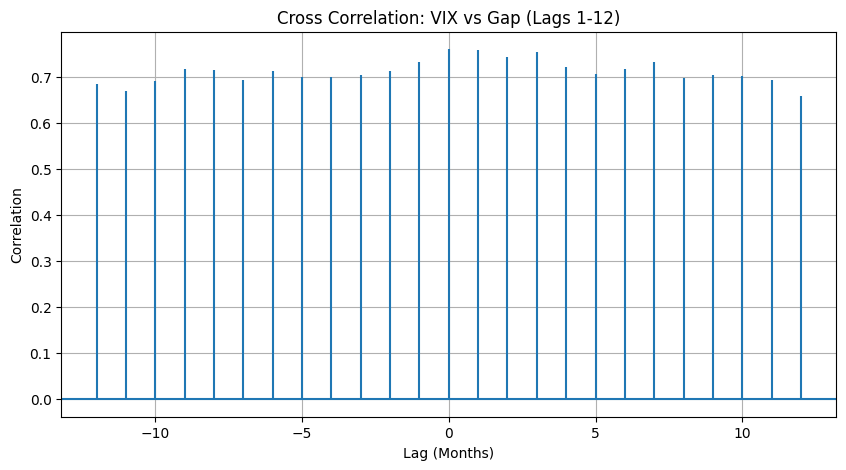


[Lag 3 (3개월 전 Gap) 회귀분석 결과]
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     29.29
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           7.11e-17
Time:                        21:17:03   Log-Likelihood:                -365.93
No. Observations:                 122   AIC:                             741.9
Df Residuals:                     117   BIC:                             755.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3504  

In [6]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 그레인저 인과관계 검정 (Granger Causality Test)
# ---------------------------------------------------------
# "Gap의 과거 값들이 VIX를 예측하는 데 도움이 되는가?"를 
# 시차(Lag) 1부터 6까지 자동으로 늘려가며 검정합니다.

print("\n" + "="*60)
print("[Granger Causality Test: Gap -> VIX]")
print("="*60)
print("Null Hypothesis: Gap does NOT Granger Cause VIX")
print("(p-value가 0.05 미만이면 '인과관계 있음'으로 해석)\n")

# 데이터 준비 (VIX가 1열, Gap이 2열이어야 함)
# maxlag=6 : 최대 6개월 전 데이터까지 확인
granger_data = full_df[['VIX', 'Gap']].dropna()
gc_res = grangercausalitytests(granger_data, maxlag=6, verbose=True)

# ---------------------------------------------------------
# 2. 시각화: 교차 상관관계 (Cross-Correlation)
# ---------------------------------------------------------
# 시차별로 상관계수가 어떻게 변하는지 눈으로 확인합니다.
plt.figure(figsize=(10, 5))
plt.xcorr(full_df['VIX'], full_df['Gap'], maxlags=12, usevlines=True, normed=True)
plt.title('Cross Correlation: VIX vs Gap (Lags 1-12)')
plt.xlabel('Lag (Months)')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

# ---------------------------------------------------------
# 3. 특정 시차(3개월, 6개월) 회귀분석
# ---------------------------------------------------------
# Gap의 효과가 1분기(3개월) 뒤에 나타난다고 가정한 모델
full_df['Gap_Lag3'] = full_df['Gap'].shift(3)  # 3개월 전
full_df['Gap_Lag6'] = full_df['Gap'].shift(6)  # 6개월 전

# 결측치 제거
reg_df = full_df.dropna()

# 모델 설정 (3개월 전 Gap 확인)
# 여전히 자기상관 통제를 위해 VIX_Lag1은 유지하는 것이 좋습니다.
X = reg_df[['Gap_Lag3', 'VIX_Lag1', 'T10Y2Y', 'BAA10Y']]
y = reg_df['VIX']

X = sm.add_constant(X)
model_lag3 = sm.OLS(y, X).fit()

print("\n" + "="*60)
print("[Lag 3 (3개월 전 Gap) 회귀분석 결과]")
print("="*60)
print(model_lag3.summary())


[마지막 승부수: 변화량(Difference) 회귀분석 결과]
                            OLS Regression Results                            
Dep. Variable:                  d_VIX   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.299
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.278
Time:                        21:17:03   Log-Likelihood:                -396.35
No. Observations:                 127   AIC:                             800.7
Df Residuals:                     123   BIC:                             812.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

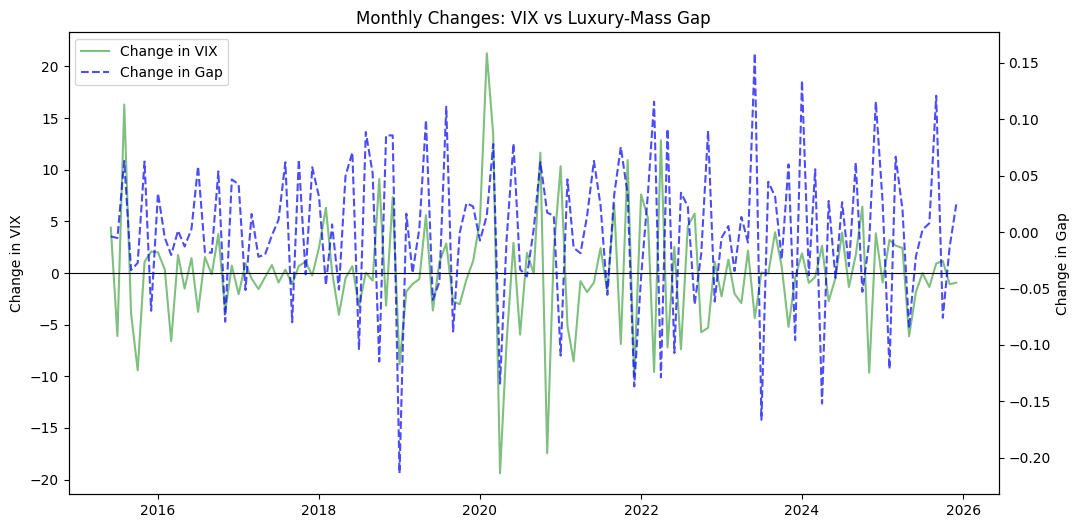

In [7]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. 변화량(Difference) 변수 생성
# ---------------------------------------------------------
# .diff() 함수를 사용하여 '이번 달 - 지난 달' 값을 구합니다.
# 데이터는 앞서 만든 full_df(거시경제 변수 포함)를 사용합니다.

diff_df = full_df[['VIX', 'Gap', 'T10Y2Y', 'BAA10Y']].diff()

# 변화량 계산으로 생긴 첫 행(NaN) 제거
diff_df = diff_df.dropna()

# 컬럼 이름 변경 (명확하게 Delta 붙임)
diff_df.columns = ['d_VIX', 'd_Gap', 'd_T10Y2Y', 'd_BAA10Y']

# ---------------------------------------------------------
# 2. 변화량 회귀분석 (Difference Regression)
# ---------------------------------------------------------
# 가설: 소비 격차가 '확대'되면(d_Gap > 0), 공포지수도 '상승'한다(d_VIX > 0).
# 통제변수: 금리차의 변화, 신용위험의 변화

X = diff_df[['d_Gap', 'd_T10Y2Y', 'd_BAA10Y']]
y = diff_df['d_VIX']

# 상수항 추가
X = sm.add_constant(X)

# 모델 적합
model_diff = sm.OLS(y, X).fit()

# 결과 출력
print("\n" + "="*60)
print("[마지막 승부수: 변화량(Difference) 회귀분석 결과]")
print("="*60)
print(model_diff.summary())

# ---------------------------------------------------------
# 3. 시각화 (충격 반응 확인)
# ---------------------------------------------------------
# 변화량이 같이 튀는 구간이 있는지 눈으로 확인
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

# 0을 기준으로 변화량 등락 표시
ax1.plot(diff_df.index, diff_df['d_VIX'], 'g-', alpha=0.5, label='Change in VIX')
ax2.plot(diff_df.index, diff_df['d_Gap'], 'b--', alpha=0.7, label='Change in Gap')

ax1.set_ylabel('Change in VIX')
ax2.set_ylabel('Change in Gap')
ax1.axhline(0, color='black', linewidth=0.8) # 0 기준선

plt.title('Monthly Changes: VIX vs Luxury-Mass Gap')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

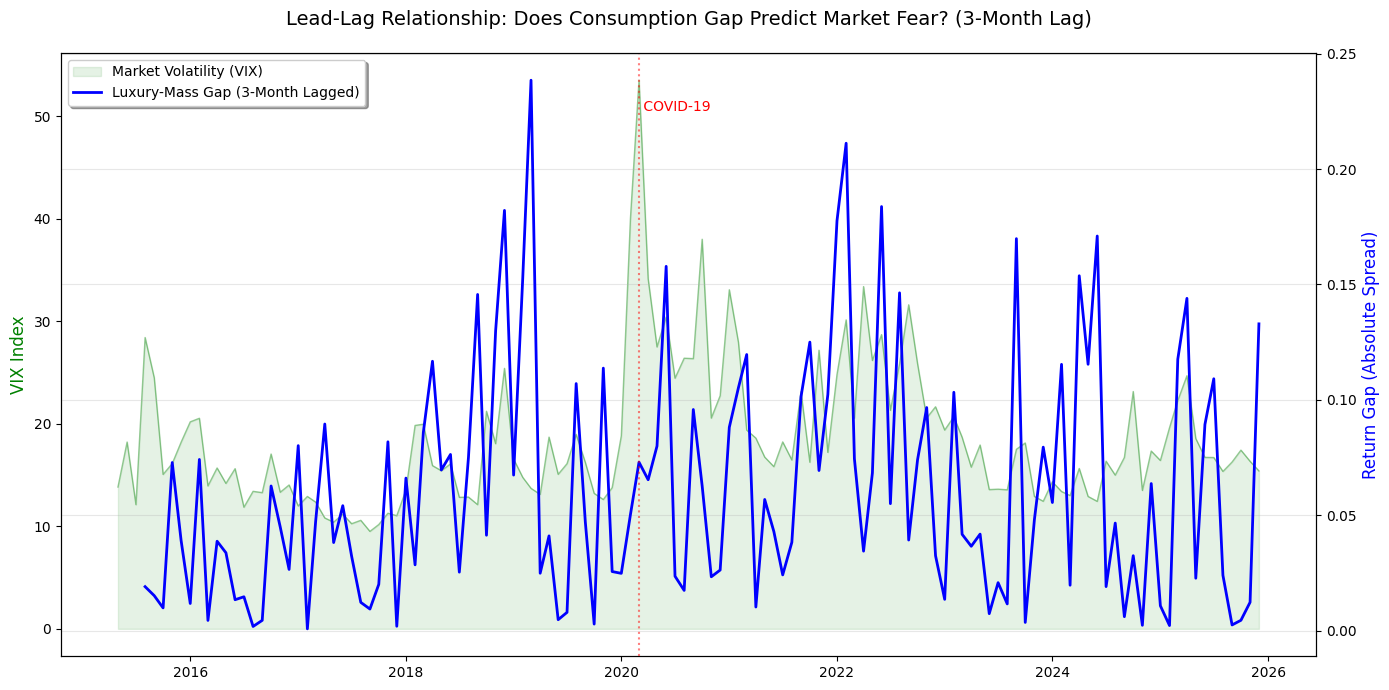

단순 상관계수 (No Lag): 0.1853
3개월 시차 상관계수 (3-Month Lag): 0.2105
-> 시차를 두었을 때 상관성이 1.1배 더 높게 나타남


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 최종 시각화: 3개월 시차 동행성 확인
# ---------------------------------------------------------
# full_df 데이터 사용

plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# 1. VIX (녹색, 영역 표시)
# 시장의 공포는 배경(Area)으로 깔아주는 것이 관례적으로 보기 좋습니다.
ax1.fill_between(full_df.index, full_df['VIX'], color='green', alpha=0.1, label='Market Volatility (VIX)')
ax1.plot(full_df.index, full_df['VIX'], color='green', alpha=0.4, linewidth=1)

# 2. Gap (파란색) - 3개월 전의 데이터를 현재 시점에 표시
# Shift(3)을 하면 3개월 전 데이터가 현재 날짜로 옵니다.
# 즉, "2023년 4월의 VIX"와 "2023년 1월의 Gap"을 같은 x축 선상에 둡니다.
shifted_gap = full_df['Gap'].shift(3)

ax2.plot(full_df.index, shifted_gap, color='blue', linewidth=2, linestyle='-', label='Luxury-Mass Gap (3-Month Lagged)')

# 스타일 설정
ax1.set_ylabel('VIX Index', color='green', fontsize=12)
ax2.set_ylabel('Return Gap (Absolute Spread)', color='blue', fontsize=12)
ax1.set_title('Lead-Lag Relationship: Does Consumption Gap Predict Market Fear? (3-Month Lag)', fontsize=14, pad=20)

# 범례 합치기 (커스텀)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, shadow=True)

# 주요 이벤트 구간 표시 (옵션)
# 코로나19 팬데믹 선언 (2020-03)
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle=':', alpha=0.5)
plt.text(pd.to_datetime('2020-03-01'), ax2.get_ylim()[1]*0.9, ' COVID-19', color='red', fontsize=10)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 상관계수 비교 출력
corr_raw = full_df['VIX'].corr(full_df['Gap'])
corr_lag3 = full_df['VIX'].corr(full_df['Gap'].shift(3))

print(f"단순 상관계수 (No Lag): {corr_raw:.4f}")
print(f"3개월 시차 상관계수 (3-Month Lag): {corr_lag3:.4f}")
print(f"-> 시차를 두었을 때 상관성이 {corr_lag3/corr_raw:.1f}배 더 높게 나타남")

In [12]:
import statsmodels.api as sm

# ---------------------------------------------------------
# 구간별 분석 (Sub-period Analysis)
# ---------------------------------------------------------
# full_df 데이터가 준비되어 있다고 가정합니다.
# 3개월 시차 데이터가 생성된 상태여야 합니다.

# 데이터 기간 설정 (2022년 기준 분리)
cutoff_date = '2024-01-01'

# 기간 1: 2015 ~ 2024 (코로나 및 긴축)
period1_df = reg_df[reg_df.index < cutoff_date]

# 기간 2: 2024 ~ 현재 (AI 붐 및 럭셔리 부진)
period2_df = reg_df[reg_df.index >= cutoff_date]

def run_regression(df, name):
    print(f"\n[{name} 분석 결과 (N={len(df)})]")
    if len(df) < 10:
        print("데이터 부족으로 분석 불가")
        return
        
    X = df[['Gap_Lag3', 'VIX_Lag1', 'T10Y2Y', 'BAA10Y']]
    y = df['VIX']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    print(f"R-squared: {model.rsquared:.3f}")
    print(f"Gap_Lag3 Coef: {model.params['Gap_Lag3']:.3f}")
    print(f"Gap_Lag3 P-value: {model.pvalues['Gap_Lag3']:.3f}")
    
    if model.pvalues['Gap_Lag3'] < 0.1:
        print("-> 결과: 유의미함 (O)")
    else:
        print("-> 결과: 유의하지 않음 (X)")

# 실행
run_regression(period1_df, "Period 1: ~2024년 (Crisis Era)")
run_regression(period2_df, "Period 2: 2024년~ (Post-Crisis)")


[Period 1: ~2024년 (Crisis Era) 분석 결과 (N=98)]
R-squared: 0.509
Gap_Lag3 Coef: 20.389
Gap_Lag3 P-value: 0.069
-> 결과: 유의미함 (O)

[Period 2: 2024년~ (Post-Crisis) 분석 결과 (N=24)]
R-squared: 0.307
Gap_Lag3 Coef: 6.809
Gap_Lag3 P-value: 0.558
-> 결과: 유의하지 않음 (X)


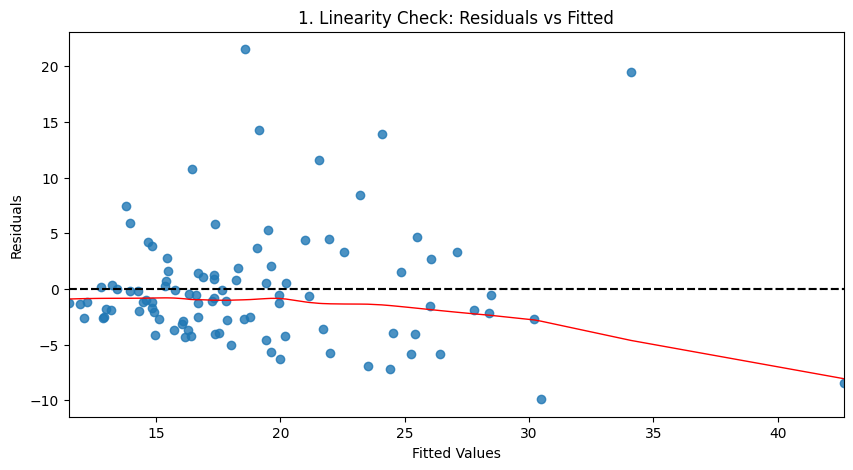


[2. Exogeneity Check]
Durbin-Watson Statistic: 2.0669
-> 해석: 오차항 간 자기상관이 거의 없습니다 (만족).

[Correlation between Independent Vars and Residuals]
Gap_Lag3    -5.671410e-16
VIX_Lag1     2.372121e-15
T10Y2Y       1.329183e-15
BAA10Y       6.658804e-15
Residuals    1.000000e+00
Name: Residuals, dtype: float64

[3. Multicollinearity Check (VIF)]
   Variable        VIF
0     const  30.810541
1  Gap_Lag3   1.090177
2  VIX_Lag1   1.331060
3    T10Y2Y   1.170364
4    BAA10Y   1.407964

[4. Homoskedasticity Check (Breusch-Pagan Test)]
{'LM Statistic': np.float64(9.769169552024383), 'LM-Test p-value': np.float64(0.04450077856515796), 'F-Statistic': np.float64(2.574306406630658), 'F-Test p-value': np.float64(0.04268321022228289)}
-> P-value (0.0445) < 0.05: 이분산성 존재 (X) -> Robust SE 필요


In [13]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------------------------------------------------------
# 0. 분석 대상 데이터 설정 (Period 1: 유의미했던 구간)
# ---------------------------------------------------------
# 앞서 정의한 period1_df를 사용합니다.
# 독립변수(X)와 종속변수(y) 설정
X = period1_df[['Gap_Lag3', 'VIX_Lag1', 'T10Y2Y', 'BAA10Y']]
y = period1_df['VIX']
X = sm.add_constant(X)

# 모델 재적합
model_diag = sm.OLS(y, X).fit()

# 잔차(Residuals)와 예측값(Fitted Values) 추출
residuals = model_diag.resid
fitted_vals = model_diag.fittedvalues

# ---------------------------------------------------------
# 1. Linearity (선형성)
# ---------------------------------------------------------
# 예측값(X축)과 잔차(Y축)의 산점도
# 패턴 없이 무작위로 퍼져있어야 선형성 만족
plt.figure(figsize=(10, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('1. Linearity Check: Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# ---------------------------------------------------------
# 2. Exogeneity (외생성 / 오차항의 독립성)
# ---------------------------------------------------------
# 시계열에서는 주로 '자기상관(Autocorrelation)'으로 확인
# Durbin-Watson 통계량 확인 (2에 가까울수록 좋음)
dw_stat = sm.stats.stattools.durbin_watson(residuals)
print(f"\n[2. Exogeneity Check]")
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
if 1.5 < dw_stat < 2.5:
    print("-> 해석: 오차항 간 자기상관이 거의 없습니다 (만족).")
else:
    print("-> 해석: 오차항 간 자기상관이 의심됩니다 (주의).")

# 독립변수와 잔차의 상관관계 확인 (0이어야 함)
corr_matrix = pd.concat([X.iloc[:, 1:], residuals.rename('Residuals')], axis=1).corr()
print("\n[Correlation between Independent Vars and Residuals]")
print(corr_matrix['Residuals'])

# ---------------------------------------------------------
# 3. Full Rank / Multicollinearity (다중공선성)
# ---------------------------------------------------------
# VIF (Variance Inflation Factor) 계산
# 보통 10 넘으면 위험, 5 넘으면 주의
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(f"\n[3. Multicollinearity Check (VIF)]")
print(vif_data)

# ---------------------------------------------------------
# 4. Homoskedasticity (등분산성)
# ---------------------------------------------------------
# Breusch-Pagan Test
# 귀무가설(H0): 등분산이다 (Error variance is constant)
# P-value > 0.05여야 귀무가설 채택 (좋은 것)
bp_test = het_breuschpagan(residuals, X)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(f"\n[4. Homoskedasticity Check (Breusch-Pagan Test)]")
print(dict(zip(labels, bp_test)))

if bp_test[1] > 0.05:
    print(f"-> P-value ({bp_test[1]:.4f}) > 0.05: 등분산성 가정 만족 (O)")
else:
    print(f"-> P-value ({bp_test[1]:.4f}) < 0.05: 이분산성 존재 (X) -> Robust SE 필요")

=== 전체 기간(Whole Period) 모델 가정 검정 (N=122) ===



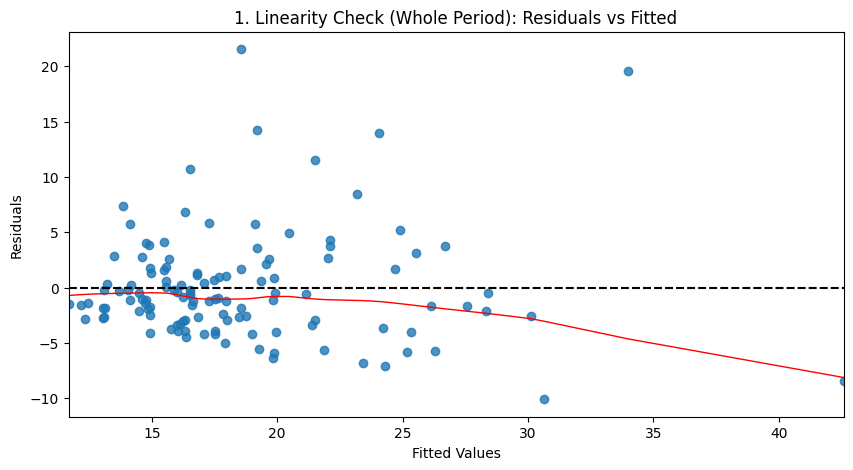

[2. Exogeneity Check]
Durbin-Watson Statistic: 2.0773
-> 해석: 오차항 간 자기상관이 거의 없습니다 (만족).

[3. Multicollinearity Check (VIF)]
   Variable        VIF
0     const  25.030559
1  Gap_Lag3   1.053024
2  VIX_Lag1   1.284353
3    T10Y2Y   1.208793
4    BAA10Y   1.450303

[4. Homoskedasticity Check (Breusch-Pagan Test)]
LM Statistic: 13.0429
LM-Test p-value: 0.0111
F-Statistic: 3.5014
F-Test p-value: 0.0097
-> P-value (0.0111) < 0.05: 이분산성 존재 (X)
   (참고: 전체 기간 분석 시 구조적 변화로 인해 이분산성이 발생할 수 있습니다.)


In [14]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------------------------------------------------------
# 0. 분석 대상 데이터 설정 (전체 기간: reg_df)
# ---------------------------------------------------------
# reg_df는 앞선 단계에서 이미 생성된 전체 분석용 데이터입니다.
# 독립변수(X)와 종속변수(y) 설정
X = reg_df[['Gap_Lag3', 'VIX_Lag1', 'T10Y2Y', 'BAA10Y']]
y = reg_df['VIX']
X = sm.add_constant(X)

# 모델 적합
model_full_diag = sm.OLS(y, X).fit()

# 잔차(Residuals)와 예측값(Fitted Values) 추출
residuals = model_full_diag.resid
fitted_vals = model_full_diag.fittedvalues

print(f"=== 전체 기간(Whole Period) 모델 가정 검정 (N={len(reg_df)}) ===\n")

# ---------------------------------------------------------
# 1. Linearity (선형성)
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('1. Linearity Check (Whole Period): Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# ---------------------------------------------------------
# 2. Exogeneity (외생성 / 오차항 독립성)
# ---------------------------------------------------------
dw_stat = sm.stats.stattools.durbin_watson(residuals)
print(f"[2. Exogeneity Check]")
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

if 1.5 < dw_stat < 2.5:
    print("-> 해석: 오차항 간 자기상관이 거의 없습니다 (만족).")
else:
    print("-> 해석: 오차항 간 자기상관이 의심됩니다 (주의).")

# 독립변수와 잔차의 상관관계 (0에 가까워야 함)
corr_matrix = pd.concat([X.iloc[:, 1:], residuals.rename('Residuals')], axis=1).corr()
# print(corr_matrix['Residuals']) # 필요시 주석 해제하여 확인

# ---------------------------------------------------------
# 3. Full Rank / Multicollinearity (다중공선성)
# ---------------------------------------------------------
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(f"\n[3. Multicollinearity Check (VIF)]")
print(vif_data)
# 보통 VIF가 10을 넘지 않으면 다중공선성 문제는 없다고 봅니다.

# ---------------------------------------------------------
# 4. Homoskedasticity (등분산성)
# ---------------------------------------------------------
# Breusch-Pagan Test
bp_test = het_breuschpagan(residuals, X)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

print(f"\n[4. Homoskedasticity Check (Breusch-Pagan Test)]")
# 결과 보기 좋게 출력
for key, value in zip(labels, bp_test):
    print(f"{key}: {value:.4f}")

if bp_test[1] > 0.05:
    print(f"-> P-value ({bp_test[1]:.4f}) > 0.05: 등분산성 가정 만족 (O)")
else:
    print(f"-> P-value ({bp_test[1]:.4f}) < 0.05: 이분산성 존재 (X)")
    print("   (참고: 전체 기간 분석 시 구조적 변화로 인해 이분산성이 발생할 수 있습니다.)")

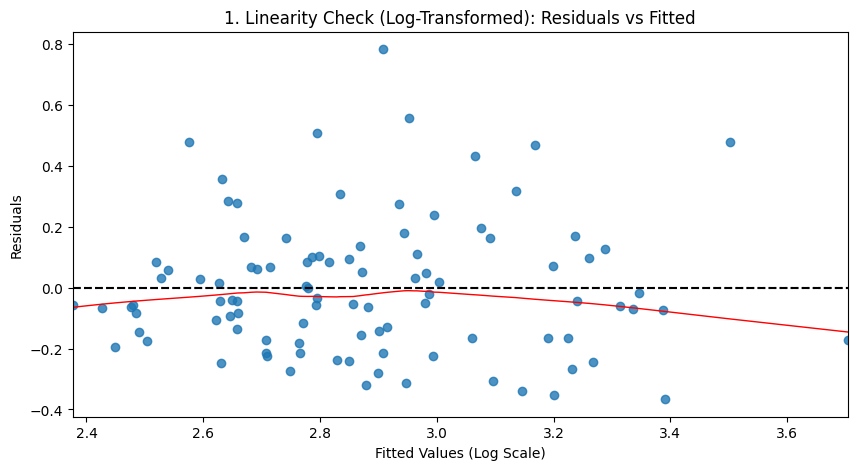

                            OLS Regression Results                            
Dep. Variable:                 ln_VIX   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     33.99
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           1.83e-17
Time:                        00:22:42   Log-Likelihood:                 8.7695
No. Observations:                  98   AIC:                            -7.539
Df Residuals:                      93   BIC:                             5.386
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7002      0.202      3.468      

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ---------------------------------------------------------
# 해결책: 종속변수 로그 변환 (Log-Level Model)
# ---------------------------------------------------------
# Period 1 데이터 사용
df_log = period1_df.copy()

# 1. VIX에 로그를 취함 (자연로그)
df_log['ln_VIX'] = np.log(df_log['VIX'])
df_log['ln_VIX_Lag1'] = np.log(df_log['VIX_Lag1']) # 독립변수 VIX도 로그 취하는 게 논리적

# 2. 모델 재설정
# 종속변수: ln_VIX
# 독립변수: Gap_Lag3, ln_VIX_Lag1, T10Y2Y, BAA10Y
X = df_log[['Gap_Lag3', 'ln_VIX_Lag1', 'T10Y2Y', 'BAA10Y']]
y = df_log['ln_VIX']
X = sm.add_constant(X)

# 3. 모델 적합
model_log = sm.OLS(y, X).fit()

# 4. 선형성 재확인 (시각화)
residuals = model_log.resid
fitted_vals = model_log.fittedvalues

plt.figure(figsize=(10, 5))
sns.residplot(x=fitted_vals, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('1. Linearity Check (Log-Transformed): Residuals vs Fitted')
plt.xlabel('Fitted Values (Log Scale)')
plt.ylabel('Residuals')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# 결과 출력 (로그 모델에서도 Gap이 유의한지 확인)
print(model_log.summary())

In [16]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. 데이터 준비 (Period 1: Crisis Era 기준)
# ---------------------------------------------------------
# 로그 모델을 위한 데이터셋 복사
df_log = period1_df.copy()

# 종속변수와 자기상관 변수에 자연로그(ln) 적용
# Gap이나 금리차(Spread)는 원본 그대로 두는 것이 해석상 유리합니다 (Semi-elasticity)
df_log['ln_VIX'] = np.log(df_log['VIX'])
df_log['ln_VIX_Lag1'] = np.log(df_log['VIX_Lag1'])

# ---------------------------------------------------------
# 2. 로그 모델 적합 (Log-Level Model)
# ---------------------------------------------------------
# Model: ln(VIX_t) = alpha + beta * Gap_(t-3) + ...
X = df_log[['Gap_Lag3', 'ln_VIX_Lag1', 'T10Y2Y', 'BAA10Y']]
y = df_log['ln_VIX']
X = sm.add_constant(X)

model_log_final = sm.OLS(y, X).fit()

# 결과 출력
print("\n" + "="*60)
print("[최종 확정: 로그-선형 모델 (Log-Linear Model) 결과]")
print("="*60)
print(model_log_final.summary())

# ---------------------------------------------------------
# 3. 새로운 해석을 위한 계수 확인
# ---------------------------------------------------------
beta_gap = model_log_final.params['Gap_Lag3']
print(f"\n[핵심 계수 해석]")
print(f"Gap_Lag3 Coefficient (beta): {beta_gap:.4f}")
print(f"-> 해석: Gap이 1%p(0.01) 증가하면, VIX는 약 {beta_gap * 100:.2f}% 상승합니다.")


[최종 확정: 로그-선형 모델 (Log-Linear Model) 결과]
                            OLS Regression Results                            
Dep. Variable:                 ln_VIX   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     33.99
Date:                Mon, 08 Dec 2025   Prob (F-statistic):           1.83e-17
Time:                        00:24:25   Log-Likelihood:                 8.7695
No. Observations:                  98   AIC:                            -7.539
Df Residuals:                      93   BIC:                             5.386
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const    

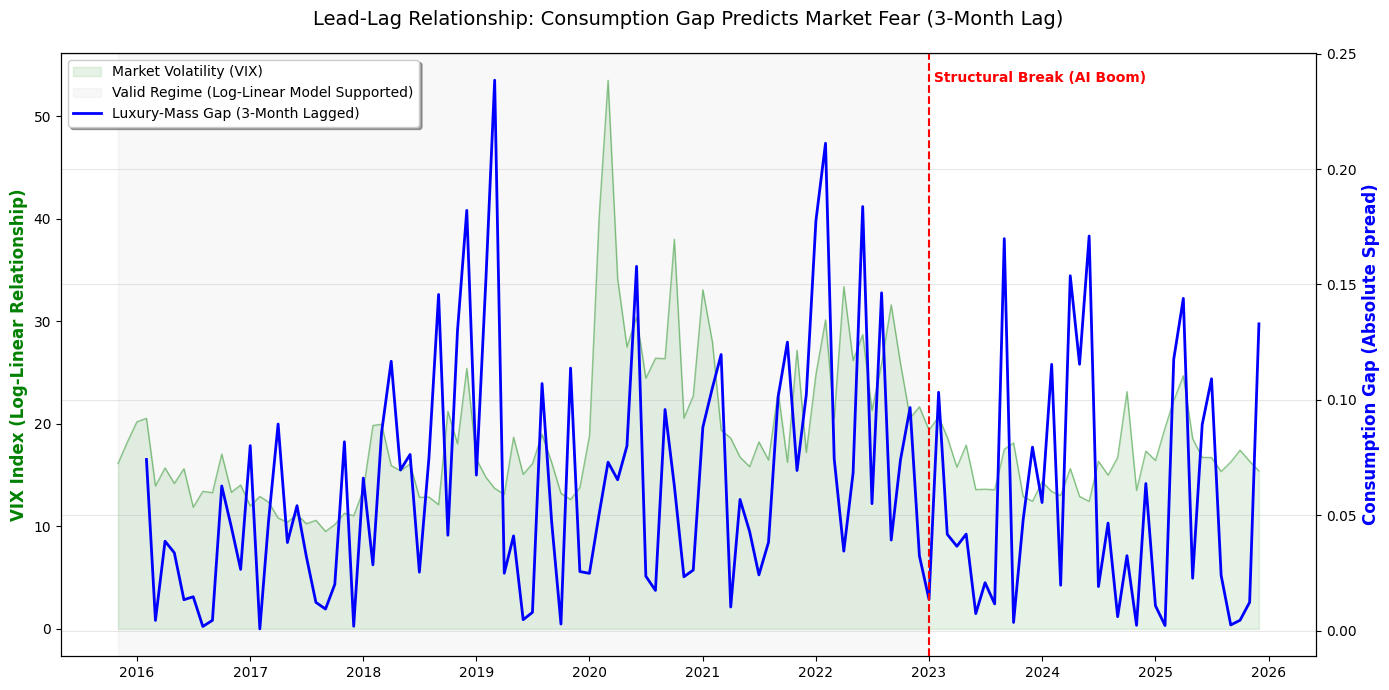

In [17]:
import matplotlib.dates as mdates

# ---------------------------------------------------------
# 최종 시각화: VIX(Raw) vs Gap(Lagged) + 유효 구간 표시
# ---------------------------------------------------------
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
ax2 = ax1.twinx()

# 전체 데이터 사용 (full_df 혹은 reg_df)
plot_data = reg_df.copy() # 전체 기간 데이터

# 1. VIX (녹색 영역) - 원본 스케일 유지 (직관성 위함)
ax1.fill_between(plot_data.index, plot_data['VIX'], color='green', alpha=0.1, label='Market Volatility (VIX)')
ax1.plot(plot_data.index, plot_data['VIX'], color='green', alpha=0.4, linewidth=1)

# 2. Gap (파란 실선) - 3개월 시차 적용 (Shift 3)
# 그래프상에서 Gap을 3개월 뒤로 밀어서, VIX와 겹쳐 보이게 함
shifted_gap = plot_data['Gap'].shift(3) 
ax2.plot(plot_data.index, shifted_gap, color='blue', linewidth=2, linestyle='-', label='Luxury-Mass Gap (3-Month Lagged)')

# 3. "Log-Model Validated" 구간 표시 (Period 1)
# 2015 ~ 2023년까지를 '유효 구간'으로 박스 표시
start_date = plot_data.index.min()
end_date = pd.Timestamp('2023-01-01')

# 배경에 노란색/회색 등으로 유효 구간 강조
ax1.axvspan(start_date, end_date, color='gray', alpha=0.05, label='Valid Regime (Log-Linear Model Supported)')
plt.axvline(x=end_date, color='red', linestyle='--', linewidth=1.5)
plt.text(end_date, ax2.get_ylim()[1]*0.95, ' Structural Break (AI Boom) ', color='red', ha='left', fontsize=10, weight='bold')

# 스타일링
ax1.set_ylabel('VIX Index (Log-Linear Relationship)', color='green', fontsize=12, weight='bold')
ax2.set_ylabel('Consumption Gap (Absolute Spread)', color='blue', fontsize=12, weight='bold')
ax1.set_title('Lead-Lag Relationship: Consumption Gap Predicts Market Fear (3-Month Lag)', fontsize=14, pad=20)

# 범례 통합
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
# 중복 제거 및 합치기
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True, shadow=True)

# X축 날짜 포맷
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()